In [2]:
%matplotlib inline

import warnings
import os
from pathlib import Path
import quandl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, IncrementalPCA, FastICA

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.random.seed(42)

In [6]:
shared = prices.columns.intersection(stocks.index)
prices = prices.loc['2010':, shared]
stocks = stocks.loc[shared, ['marketcap', 'ipoyear', 'sector']]

In [43]:
idx = pd.IndexSlice
with pd.HDFStore('../../data/assets.h5') as store:
    returns = (store['quandl/wiki/prices']
               .loc[idx['2010':'2018', :], 'adj_close']
               .unstack('ticker')
               .pct_change())

In [44]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2113 entries, 2010-01-04 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 51.6 MB


In [45]:
returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
returns = returns.dropna(thresh=int(returns.shape[1] * .95))
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2070 entries, 2010-01-05 to 2018-03-27
Columns: 2026 entries, A to ZUMZ
dtypes: float64(2026)
memory usage: 32.0 MB


In [81]:
returns_sample = returns.sample(n=500)

In [82]:
daily_avg = returns_sample.mean(1)
returns_sample = returns_sample.apply(lambda x: x.fillna(daily_avg))

In [83]:
pca = PCA()
pca.fit(returns_sample)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

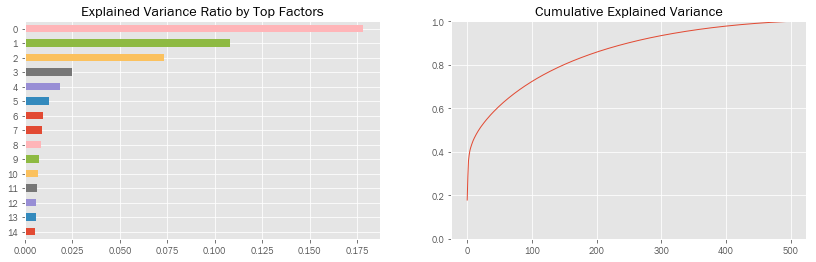

In [84]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
pd.Series(pca.explained_variance_ratio_).iloc[:15].sort_values().plot.barh(title='Explained Variance Ratio by Top Factors',ax=axes[0]);
pd.Series(pca.explained_variance_ratio_).cumsum().plot(ylim=(0,1),ax=axes[1], title='Cumulative Explained Variance');